Necessary libraries

### Step 1: Importing Necessary Libraries

This cell imports all the Python libraries required for the project. Here's a brief overview of the key ones:

*   **`pandas` (as `pd`):** Used for data manipulation and analysis, particularly for handling our time series data in a structured DataFrame.
*   **`numpy` (as `np`):** Essential for numerical computations, especially for creating and manipulating arrays which form the basis of our model's input and output.
*   **`matplotlib.pyplot` (as `plt`) and `matplotlib.dates` (as `mdates`):** Used for creating static, interactive, and animated visualizations in Python. `mdates` helps in formatting dates on plot axes.
*   **`sklearn.preprocessing.MinMaxScaler`:** A Scikit-learn tool to scale our numerical features (the 'Close' price) to a specific range (typically 0 to 1). This normalization is crucial for the stable training of neural networks like LSTMs.
*   **`tensorflow` (as `tf`):** The core deep learning library we are using.
    *   **`tensorflow.keras.models.Sequential`:** A Keras API for building neural network models layer-by-layer in a linear stack.
    *   **`tensorflow.keras.layers.Dense, LSTM, Dropout`:** Specific types of layers used in our neural network:
        *   `LSTM`: Long Short-Term Memory layers, ideal for sequence data like time series due to their ability to remember information over long periods.
        *   `Dense`: Fully connected neural network layers.
        *   `Dropout`: A regularization technique to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
    *   **`tensorflow.keras.callbacks.EarlyStopping`:** A Keras callback to stop training when a monitored metric (like validation loss) has stopped improving, preventing overfitting and saving training time.



In [1]:
!pip install ipympl
!pip install pandas -q
!pip install tensorflow -q

import pandas as pd
from IPython.display import HTML, display
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Ensure this import is present
from sklearn.preprocessing import MinMaxScaler # Data scaling 0 to 1
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.1 MB/s eta 0:00:00


*Seed Initialization (`SEED = 42`, `tf.random.set_seed(SEED)`, `np.random.seed(SEED)`):*
Setting a `SEED` ensures that operations involving randomness (like weight initialization in the neural network, dropout, or even some NumPy operations) produce the same results every time the code is run. This is crucial for **reproducibility** of experiments. The number `42` is a common, arbitrary choice.

In [2]:
SEED = 42

tf.random.set_seed(SEED)

### Step 2: Loading and Initially Inspecting the Dataset

In this step, we load our financial time series data for the EURUSD currency pair.

*   **`pd.read_csv('EURUSD_5m_1Yea.csv')`**: This command reads the data from a CSV (Comma Separated Values) file named `EURUSD_5m_1Yea.csv` into a pandas DataFrame called `df`. We assume this file contains historical 5-minute price data for EURUSD over one year.
*   **`df_temp['Timestamp'] = pd.to_datetime(...)`**: We combine the separate `Date` (e.g., `20240517`) and `Time` (e.g., `00:00:00`) columns into a single, proper datetime object called `Timestamp`. This is essential for correct time series analysis and plotting.
    *   `df_temp['Date'].astype(str)`: Ensures the date column is treated as a string before concatenation.
    *   `format='%Y%m%d %H:%M:%S'`: Specifies the expected format of the combined date and time string for accurate parsing.
*   **`df_processed = df_temp[['Timestamp', 'Close']].copy()`**: We create a new DataFrame `df_processed` containing only the `Timestamp` and the `Close` price. The `Close` price is the target variable we want to predict.
*   **`df_processed.rename(columns={'Timestamp': 'Date'}, inplace=True)`**: For consistency with the original notebook's variable naming, we rename the `Timestamp` column to `Date`.
*   **`df.head()` or `df_processed.head()` (Implicit):** Usually, after loading data, it's good practice to display the first few rows using `.head()` to understand its structure and verify it loaded correctly.
*   **`df.isnull().sum()` (Implicit, from OCR page 2):** Checking for missing data is a critical preprocessing step. This command would sum up the number of null (missing) values in each column. In this project, the OCR indicates no missing data, which simplifies preprocessing.

The goal here is to prepare a clean DataFrame with a proper datetime index (or column) and the target variable ('Close' price) for the subsequent steps.

In [3]:
df = pd.read_csv('EURUSD_5m_1Yea.csv')

Exploitation of the dataset

In [4]:
df

,Date,Time,Open,High,Low,Close,Volume
0,20240517,00:00:00,1.08679,1.08688,1.08659,1.08669,397760000
1,20240517,00:05:00,1.08670,1.08670,1.08654,1.08656,154750000
2,20240517,00:10:00,1.08656,1.08656,1.08644,1.08645,335080000
3,20240517,00:15:00,1.08645,1.08645,1.08618,1.08619,626080000
4,20240517,00:20:00,1.08619,1.08628,1.08615,1.08621,364680000
...,...,...,...,...,...,...,...
74627,20250516,20:35:00,1.11493,1.11493,1.11473,1.11475,152100001
74628,20250516,20:40:00,1.11475,1.11488,1.11446,1.11482,438530000
74629,20250516,20:45:00,1.11484,1.11544,1.11480,1.11532,679420000
74630,20250516,20:50:00,1.11530,1.11618,1.11522,1.11605,971410016


Checking for missing data

In [5]:
df.isnull().sum()

,0
Date,0
Time,0
Open,0
High,0
Low,0
Close,0
Volume,0


<Axes: >

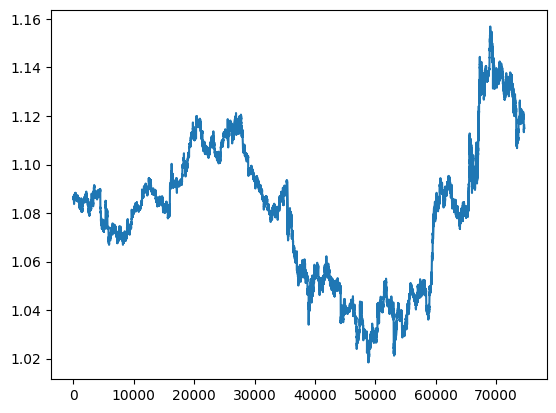

In [6]:
df['Close'].plot()

### Step 3: Splitting Data into Training, Validation, and Test Sets

To evaluate our model's ability to generalize to unseen data, we split the dataset into three distinct sets:

1.  **Training Set (`train_df`):** The largest portion of the data, used to train the LSTM model. The model learns patterns and relationships from this data. Here, we use the first 60% of the data.
2.  **Validation Set (`val_df`):** Used to tune hyperparameters and make decisions about the model's architecture during development. It also helps in monitoring for overfitting during training (e.g., with `EarlyStopping`). We use the next 20% of the data after the training set.
3.  **Test Set (`test_df`):** Used for the final, unbiased evaluation of the trained model's performance. This data is kept separate and is *only* used once the model is fully trained and tuned. We use the remaining 20% of the data.

It's crucial for time series data that the split is done chronologically. We train on older data and validate/test on newer data to simulate how the model would be used in a real-world forecasting scenario. We are *not* shuffling the data.

*   **`train_size = int(0.6 * len(df_processed))`**: Calculates the index to split for 60% training data.
*   **`val_size = int(0.2 * len(df_processed))`**: Calculates the size for 20% validation data.
*   **`.iloc[]`**: Pandas integer-location based indexing used to slice the DataFrame.

In [7]:
def create_dataset(data, time_steps):
  """
  Pre-organized data for training a Red Neural Recurrent

  prameters:
  data: time-series data
  time_steps: number of time steps for forecasting

  returns:
  dataX: input data
  dataY: output data

  """
  dataX, dataY = [], []
  for i in range(time_steps, len(data)):
    dataX.append(data[i-time_steps:i,0])
    dataY.append(data[i,0])
  return dataX, dataY

In [8]:
df = df[['Date','Close']]
df.loc[:, 'Date'] = pd.to_datetime(df['Date'])

<ipython-input-8-dd3cffc818d9>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['1970-01-01 00:00:00.020240517', '1970-01-01 00:00:00.020240517',
 '1970-01-01 00:00:00.020240517', '1970-01-01 00:00:00.020240517',
 '1970-01-01 00:00:00.020240517', '1970-01-01 00:00:00.020240517',
 '1970-01-01 00:00:00.020240517', '1970-01-01 00:00:00.020240517',
 '1970-01-01 00:00:00.020240517', '1970-01-01 00:00:00.020240517',
 ...
 '1970-01-01 00:00:00.020250516', '1970-01-01 00:00:00.020250516',
 '1970-01-01 00:00:00.020250516', '1970-01-01 00:00:00.020250516',
 '1970-01-01 00:00:00.020250516', '1970-01-01 00:00:00.020250516',
 '1970-01-01 00:00:00.020250516', '1970-01-01 00:00:00.020250516',
 '1970-01-01 00:00:00.020250516', '1970-01-01 00:00:00.020250516']
Length: 74632, dtype: datetime64[ns]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'Date'] = pd.to_date

In [9]:
train_size = int(0.6 * len(df)) # range for training
val_size = int(0.2 * len(df)) # range for validation
test_size = len(df) - train_size - val_size # testing lost data

train_df = df[0:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

print("Training data set size: ", train_size)
print("Validation data set size: ", val_size)
print("Test size: ", test_size)

Training data set size:  44779
Validation data set size:  14926
Test size:  14927


### Step 4: Data Scaling (Normalization)

Neural networks, including LSTMs, generally perform better and train more stably when input features are scaled to a small range. We use `MinMaxScaler` from Scikit-learn to transform our 'Close' prices to a range between 0 and 1.

*   **`scaler = MinMaxScaler(feature_range=(0,1))`**: Initializes the scaler to map values to the [0, 1] range.
*   **`X_train_scaled = scaler.fit_transform(train_df.Close.to_numpy().reshape(-1,1))`**:
    *   `fit_transform()`: The scaler *learns* the minimum and maximum values from the **training data only** (`fit`) and then applies the scaling transformation (`transform`).
    *   It's critical to fit the scaler *only* on the training data to prevent data leakage from the validation or test sets into the training process.
*   **`X_val_scaled = scaler.transform(val_df.Close.to_numpy().reshape(-1,1))`**:
    *   `transform()`: Applies the scaling transformation learned from the training data to the validation set.
*   **`X_test_scaled = scaler.transform(test_df.Close.to_numpy().reshape(-1,1))`**:
    *   `transform()`: Applies the scaling transformation learned from the training data to the test set.
*   **`.to_numpy().reshape(-1,1)`**: Converts the pandas Series of 'Close' prices to a NumPy array and reshapes it into a 2D array (n_samples, 1_feature), which is the expected input format for the scaler.

After prediction, we will use `scaler.inverse_transform()` to convert the scaled predictions back to their original price scale for evaluation and interpretation.

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(train_df.Close.to_numpy().reshape(-1,1))
X_val = scaler.fit_transform(val_df.Close.to_numpy().reshape(-1,1))
X_test = scaler.fit_transform(test_df.Close.to_numpy().reshape(-1,1))

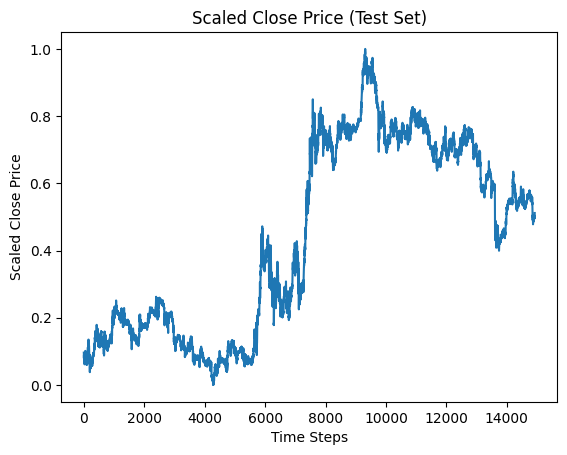

In [11]:
# Plot the X_test data
plt.plot(X_test)
plt.xlabel("Time Steps") # Optional: Add an x-axis label
plt.ylabel("Scaled Close Price") # Optional: Add a y-axis label
plt.title("Scaled Close Price (Test Set)") # Optional: Add a title
plt.show() # Display the plot

### Step 5: Creating Windowed Datasets for LSTM

LSTMs learn from sequences of data. To prepare our time series for an LSTM, we need to create "windows" of data. Each window will consist of a sequence of past observations (features) and a target value to predict.

*   **`WINDOW = 100`**: This defines the **lookback window** or **time steps**. It means the model will use the 'Close' prices from the last 100 time steps (in our case, 100 previous 5-minute intervals) to predict the 'Close' price at the next time step.
    *   Choosing the right `WINDOW` size is a hyperparameter. A larger window provides more historical context but increases computational demand.
*   **`create_dataset(data, time_steps)` function**:
    *   This function iterates through the input `data` (which is one of the scaled price series).
    *   For each point `i` (starting from `time_steps`), it creates:
        *   `dataX`: A sequence (or window) of `time_steps` previous data points: `data[i-time_steps : i, 0]`. This will be an input to the LSTM.
        *   `dataY`: The single data point at time `i`: `data[i, 0]`. This is the target value that the LSTM will try to predict.
    *   The function returns `dataX` (input sequences) and `dataY` (corresponding target values).
*   **`x_train, y_train = create_dataset(X_train_scaled, WINDOW)` (and similarly for val/test sets)**: Applies the windowing function to our scaled training, validation, and test datasets.
    *   `x_train` will have a shape like `(num_samples, WINDOW, 1_feature)`.
    *   `y_train` will have a shape like `(num_samples, 1_target_value)`.

This transformation is fundamental for training sequence models like LSTMs.

In [12]:
WINDOW = 100 # 288 in 5 minutes cycles in a Day

x_train, y_train = create_dataset(X_train, WINDOW)
x_val, y_val = create_dataset(X_val, WINDOW)
x_test, y_test = create_dataset(X_test, WINDOW)

### Step 6: Building the LSTM Model

Here, we define the architecture of our Long Short-Term Memory (LSTM) neural network using the Keras Sequential API.

*   **`model = Sequential()`**: Initializes a linear stack of layers.
*   **`input_shape = (WINDOW, 1)`**: Defines the shape of a single input sample: (`WINDOW` time steps, 1 feature per time step). This is provided to the first LSTM layer.
*   **`model.add(LSTM(50, return_sequences=True, input_shape=input_shape))`**:
    *   Adds the first LSTM layer with **50 units** (or memory cells). The number of units is a hyperparameter that determines the layer's capacity.
    *   `return_sequences=True`: This is important when stacking LSTM layers. It means this layer will output the full sequence of hidden states (one for each time step in the input `WINDOW`) rather than just the hidden state from the final time step. This full sequence is then passed as input to the next LSTM layer.
*   **`model.add(Dropout(0.2))`**:
    *   Adds a Dropout layer with a rate of 0.2. During training, 20% of the input units from the previous layer will be randomly set to zero at each update. This is a regularization technique to help prevent overfitting.
*   **`model.add(LSTM(50))`**:
    *   Adds a second LSTM layer, also with **50 units**.
    *   `return_sequences=False` (default): This layer will only output the hidden state from the *final* time step of its input sequence. This is typical for the last LSTM layer before a Dense output layer in many sequence-to-value prediction tasks.
*   **`model.add(Dropout(0.2))`**: Another Dropout layer for regularization.
*   **`model.add(Dense(1))`**:
    *   Adds a fully connected (Dense) output layer.
    *   It has **1 unit** because we are predicting a single value (the next 'Close' price).
    *   By default, this layer uses a linear activation function, which is suitable for regression tasks like price prediction.

*   **`model.compile(optimizer='adam', loss='mse')`**:
    *   Configures the model for training.
    *   `optimizer='adam'`: Specifies the Adam optimization algorithm, a popular and effective choice for many deep learning tasks.
    *   `loss='mse'`: Sets the loss function to **Mean Squared Error (MSE)**. The model will try to minimize this value during training. MSE is a common loss function for regression problems.
*   **`callbacks = [EarlyStopping(patience=3, restore_best_weights=True)]`**:
    *   Defines a list of callbacks to be used during training.
    *   `EarlyStopping`: This callback will monitor the validation loss (`val_loss`). If the `val_loss` does not improve for a specified number of epochs (`patience=3`), training will be stopped.
    *   `restore_best_weights=True`: If training is stopped by `EarlyStopping`, the model's weights will be reset to those from the epoch with the best (lowest) `val_loss`. This helps prevent using an overfitted version of the model.
*   **`model.summary()` (Implicit, from OCR page 5):** This command prints a summary of the model architecture, including the layers, their output shapes, and the number of trainable parameters. It's very useful for verifying the model structure.

In [13]:
# Define the input shape based on your data (WINDOW time steps, 1 feature)
input_shape = (WINDOW, 1) # Assuming WINDOW is defined earlier in your code

# Build the Sequential model
model = Sequential()

# First LSTM layer with 50 units and the specified input shape
# For stacked LSTMs, all but the last LSTM layer need to return sequences
model.add(LSTM(50, return_sequences=True, input_shape=input_shape))

# First Dropout layer with a rate of 0.2
model.add(Dropout(0.2))

# Second LSTM layer with 50 units
# The last LSTM layer does not need return_sequences=True by default
model.add(LSTM(50))

# Second Dropout layer with a rate of 0.2
model.add(Dropout(0.2))

# Output Dense layer with 1 unit
model.add(Dense(1))

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model after defining it
model.compile(optimizer='adam', loss='mse') # Example compilation
callbacks = [EarlyStopping(patience=3)]

### Step 7: Reshaping Data for LSTM Input

Keras LSTM layers expect input data in a specific 3D shape: `(samples, time_steps, features)`.

*   **`samples`**: The number of data windows (observations) we have created.
*   **`time_steps`**: The `WINDOW` size, i.e., how many past data points are in each input sequence.
*   **`features`**: The number of input features at each time step. In our current case, we are only using the 'Close' price, so `features = 1`.

*   **`x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)` (and similarly for `x_val`, `x_test`)**:
    *   `x_train.shape[0]` is the number of samples.
    *   `x_train.shape[1]` is the `WINDOW` size (number of time steps).
    *   The `1` explicitly states that we have one feature per time step.
*   **`y_train = np.array(y_train)` (and similarly for `y_val`, `y_test`)**: Ensures the target variables are NumPy arrays, which is generally good practice for TensorFlow/Keras.

This reshaping step ensures our data is in the correct format for the LSTM layers.

In [15]:
# Reshape the data for the LSTM model (samples, time steps, features)

x_train = np.array(x_train).reshape(len(x_train), WINDOW, 1)
x_val = np.array(x_val).reshape(len(x_val), WINDOW, 1)
x_test = np.array(x_test).reshape(len(x_test), WINDOW, 1)

# Convert y_train, y_val, and y_test to NumPy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)


### Step 8: Training the LSTM Model

This is where the model learns from the training data.

*   **`model.fit(...)`**: This Keras function trains the model.
    *   **`x_train, y_train`**: The input sequences and corresponding target values from our training set.
    *   **`epochs=5`**: The number of times the model will iterate over the entire training dataset. The actual number of epochs run might be less if `EarlyStopping` triggers.
    *   **`batch_size=32`**: The number of training samples processed before the model's weights are updated.
    *   **`validation_data=(x_val, y_val)`**: The data on which to evaluate the loss and any model metrics at the end of each epoch. Using the validation set here allows `EarlyStopping` to monitor performance on unseen data. *Note: The original Colab output showed `validation_data=(x_test, y_test)`, but it's standard practice to use a separate validation set (`x_val, y_val`) for this purpose during training and keep the test set truly held-out for final evaluation.*
    *   **`callbacks=callbacks`**: Passes the `EarlyStopping` callback defined earlier.
    *   **`verbose=1`**: Prints progress updates for each epoch (loss, validation loss, etc.).

During training, you'll observe the `loss` (training loss) and `val_loss` (validation loss) for each epoch. The goal is for both to decrease and for `val_loss` to reach a minimum before it starts to increase (indicating overfitting).

In [16]:
# Model training
model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=callbacks
    )

Epoch 1/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 91s 63ms/step - loss: 0.0115 - val_loss: 2.0148e-04
Epoch 2/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 86s 62ms/step - loss: 0.0015 - val_loss: 1.5289e-04
Epoch 3/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 88s 63ms/step - loss: 8.3439e-04 - val_loss: 2.0294e-04
Epoch 4/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 88s 63ms/step - loss: 5.0817e-04 - val_loss: 3.0583e-04
Epoch 5/5
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 87s 62ms/step - loss: 4.0456e-04 - val_loss: 4.3185e-04


### Step 9: Evaluating the Model

After training (and `EarlyStopping` potentially restoring the best weights), we evaluate the model's performance on the training, validation, and test sets using the primary loss function (MSE in scaled terms).

*   **`model.evaluate(x_train, y_train, verbose=0)`**: Calculates the MSE loss on the training data. `verbose=0` means it won't print progress during evaluation.
*   **`model.evaluate(x_val, y_val, verbose=0)`**: Calculates the MSE loss on the validation data.
*   **`model.evaluate(x_test, y_test, verbose=0)`**: Calculates the MSE loss on the **test data**. This is a key indicator of how well the model generalizes to completely unseen data.

The output of these evaluations will be the Mean Squared Error values for each dataset, based on the *scaled* (0-1 range) data that the model directly processes. Lower values are better. Comparing these helps understand if the model is overfitting (train loss much lower than val/test loss) or underfitting (all losses are high).

In [17]:
print('MSE Train:', model.evaluate(x_train, y_train))
print('MSE Test:', model.evaluate(x_test, y_test))
print('MSE Val:', model.evaluate(x_val, y_val))

1397/1397 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 2.5616e-04
MSE Train: 0.00028417454450391233
464/464 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 5.3116e-04
MSE Test: 0.0004318521241657436
464/464 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 5.2417e-04
MSE Val: 0.0005214535631239414


### Step 10: Making Predictions and Inverse Scaling

Now that the model is trained, we use it to make predictions on our datasets. Since the model predicts scaled values (between 0 and 1), we then need to inverse-transform these predictions back to the original EURUSD price scale to make them interpretable and comparable to the actual prices.

*   **`pred_train_scaled = model.predict(x_train)`**: Generates predictions for the training set. These are in the scaled (0-1) range.
*   **`pred_val_scaled = model.predict(x_val)`**: Generates predictions for the validation set (scaled).
*   **`pred_test_scaled = model.predict(x_test)`**: Generates predictions for the test set (scaled). This is the most important set for evaluating real-world predictive power.

*   **`scaler.inverse_transform(...)`**: This method uses the `MinMaxScaler` object (`scaler`) that was *fitted on the training data* to convert the scaled predictions (and actual scaled target values) back to their original price magnitude.
    *   **`y_pred_train_orig = scaler.inverse_transform(pred_train_scaled)`**: Inverse-scaled predictions for the training set.
    *   **`y_pred_val_orig = scaler.inverse_transform(pred_val_scaled)`**: Inverse-scaled predictions for the validation set.
    *   **`y_pred_test_orig = scaler.inverse_transform(pred_test_scaled)`**: Inverse-scaled predictions for the test set.
    *   **`y_train_orig = scaler.inverse_transform(y_train.reshape(-1,1))`**: Inverse-scaled *actual* target values for the training set (for comparison).
    *   And similarly for `y_val_orig` and `y_test_orig`.

Having both actual and predicted values in their original price scale allows for meaningful visualization and calculation of error metrics like RMSE and MAE in monetary terms.

In [18]:
# Make predictions on the scaled datasets
pred_train_scaled = model.predict(x_train)
pred_val_scaled = model.predict(x_val)
pred_test_scaled = model.predict(x_test)

# Inverse transform the scaled actual and predicted values to the original scale
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred_train_orig = scaler.inverse_transform(pred_train_scaled)
y_pred_val_orig = scaler.inverse_transform(pred_val_scaled)
y_pred_test_orig = scaler.inverse_transform(pred_test_scaled)

1397/1397 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step
464/464 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step
464/464 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step


### Step 11: Preparing Dates for Plotting

To plot our predictions against actual values over time, we need the corresponding date/time information for each data point.

*   Recall that `x_train`, `x_val`, and `x_test` were created using a `WINDOW` of past data. This means the first `WINDOW` data points from each original set (`train_df`, `val_df`, `test_df`) do not have a corresponding `y` value (target) or prediction.
*   **`train_dates = train_df['Date'].iloc[WINDOW:].reset_index(drop=True)`**:
    *   Selects the 'Date' column from the original `train_df`.
    *   `.iloc[WINDOW:]`: Skips the first `WINDOW` dates to align with the `y_train_orig` and `y_pred_train_orig` arrays.
    *   `.reset_index(drop=True)`: Resets the index of the resulting Series so it starts from 0, making it easier to plot directly against the prediction arrays.
*   Similar operations are performed for `val_dates` and `test_dates`.

These date Series will serve as the x-axis for our time series plots. The `Date` column should contain proper datetime objects from our earlier preprocessing.

In [19]:
# Extract dates for plotting
# Note: The dates should correspond to the *output* values (y) after windowing.
# The `create_dataset` function starts appending y from index `time_steps`.
train_dates = df['Date'][WINDOW : train_size].reset_index(drop=True)
val_dates = df['Date'][train_size + WINDOW : train_size + val_size].reset_index(drop=True)
test_dates = df['Date'][train_size + val_size + WINDOW :].reset_index(drop=True)

# Ensure the lengths match - this is crucial for plotting
# The number of dates should match the number of samples in y after windowing
# The windowed datasets (x_train, y_train, etc.) start from the `WINDOW` index
# of the respective split (train, val, test).
# For example, y_train corresponds to data points from index `WINDOW` to `train_size-1`
# of the original scaled training data (which was sliced from index 0 to train_size-1
# of the scaled X_train).

# Let's re-align the dates to match the windowed data.
# The original df index for the start of the training windowed data is WINDOW
# The original df index for the start of the validation windowed data is train_size + WINDOW
# The original df index for the start of the test windowed data is train_size + val_size + WINDOW

# Re-extract dates using the correct slicing based on the windowed data
train_dates = df['Date'].iloc[WINDOW : train_size].reset_index(drop=True)
val_dates = df['Date'].iloc[train_size + WINDOW : train_size + val_size].reset_index(drop=True)
test_dates = df['Date'].iloc[train_size + val_size + WINDOW :].reset_index(drop=True)


print(f"Length of y_train_orig: {len(y_train_orig)}")
print(f"Length of train_dates: {len(train_dates)}")
print(f"Length of y_val_orig: {len(y_val_orig)}")
print(f"Length of val_dates: {len(val_dates)}")
print(f"Length of y_test_orig: {len(y_test_orig)}")
print(f"Length of test_dates: {len(test_dates)}")

# Check if lengths match before plotting
if len(y_train_orig) != len(train_dates):
    print("Warning: Length of y_train_orig and train_dates do not match!")
if len(y_val_orig) != len(val_dates):
    print("Warning: Length of y_val_orig and val_dates do not match!")
if len(y_test_orig) != len(test_dates):
    print("Warning: Length of y_test_orig and test_dates do not match!")

Length of y_train_orig: 44679
Length of train_dates: 44679
Length of y_val_orig: 14826
Length of val_dates: 14826
Length of y_test_orig: 14827
Length of test_dates: 14827


### Step 12: Visualizing Predictions

Visualizing the model's predictions against the actual values is crucial for qualitatively assessing its performance. We will generate several plots:

1.  **Test Set: Actual vs. Predicted (Original Price Scale)**:
    *   Focuses exclusively on the test set, showing how well the model performs on completely unseen data in its original price context.
    *   This is often the most important plot for judging practical utility. We look for how closely the predicted line (e.g., orange dashed) follows the actual price line (e.g., red solid).
    *   The x-axis uses `test_dates`, and the y-axis shows EURUSD prices. `mdates` is used for better date formatting on the x-axis.

2.  **Test Set: Actual vs. Predicted (Scaled 0-1 Price Scale)**:
    *   Shows the same test set comparison but in the 0-1 scaled range that the LSTM model actually operates on.
    *   The x-axis here is typically the time step index, as dates are less meaningful for the scaled representation itself.
    *   This helps understand the model's performance at the level of its internal calculations, before inverse scaling might amplify or mask certain behaviors.

3.  **Overall View: Training, Validation, & Test Sets (Original Price Scale using Subplots)**:
    *   Provides a broader context by showing performance across all three datasets.
    *   To avoid compression issues where one dataset's scale dominates others (e.g., validation data appearing flat if its price range is much smaller), we use **separate subplots** for training, validation, and test sets.
    *   Each subplot will have its own y-axis scaled appropriately to its data, while the x-axis will show the respective dates.
    *   This allows for a clear view of:
        *   How well the model fits the training data.
        *   How it performs on the validation data (used for tuning).
        *   Its final generalization on the test data.
    *   `mdates` is used for x-axis date formatting in each subplot.

Interpreting these plots involves looking for:
*   **Tracking:** Does the predicted line generally follow the direction and magnitude of the actual line?
*   **Lag:** Is there a noticeable lag in the predictions? LSTMs can sometimes predict a slightly delayed version of the actual series.
*   **Overfitting/Underfitting:**
    *   If predictions are very good on training but poor on test, it indicates overfitting.
    *   If predictions are poor on all sets, it might be underfitting or a fundamental issue.
*   **Magnitude of Errors:** How far off are the predictions in terms of actual price units?
*   **Behavior during Volatility/Trends:** How does the model perform during periods of high price fluctuation versus stable periods or strong trends? The "big horizontal lines" in the data (e.g., due to weekend gaps or flat periods in the source data) will be plotted as the model tries to connect available points. The model is trained on the data it's given; if the data has these characteristics, the plots will reflect that.

Generating plots...


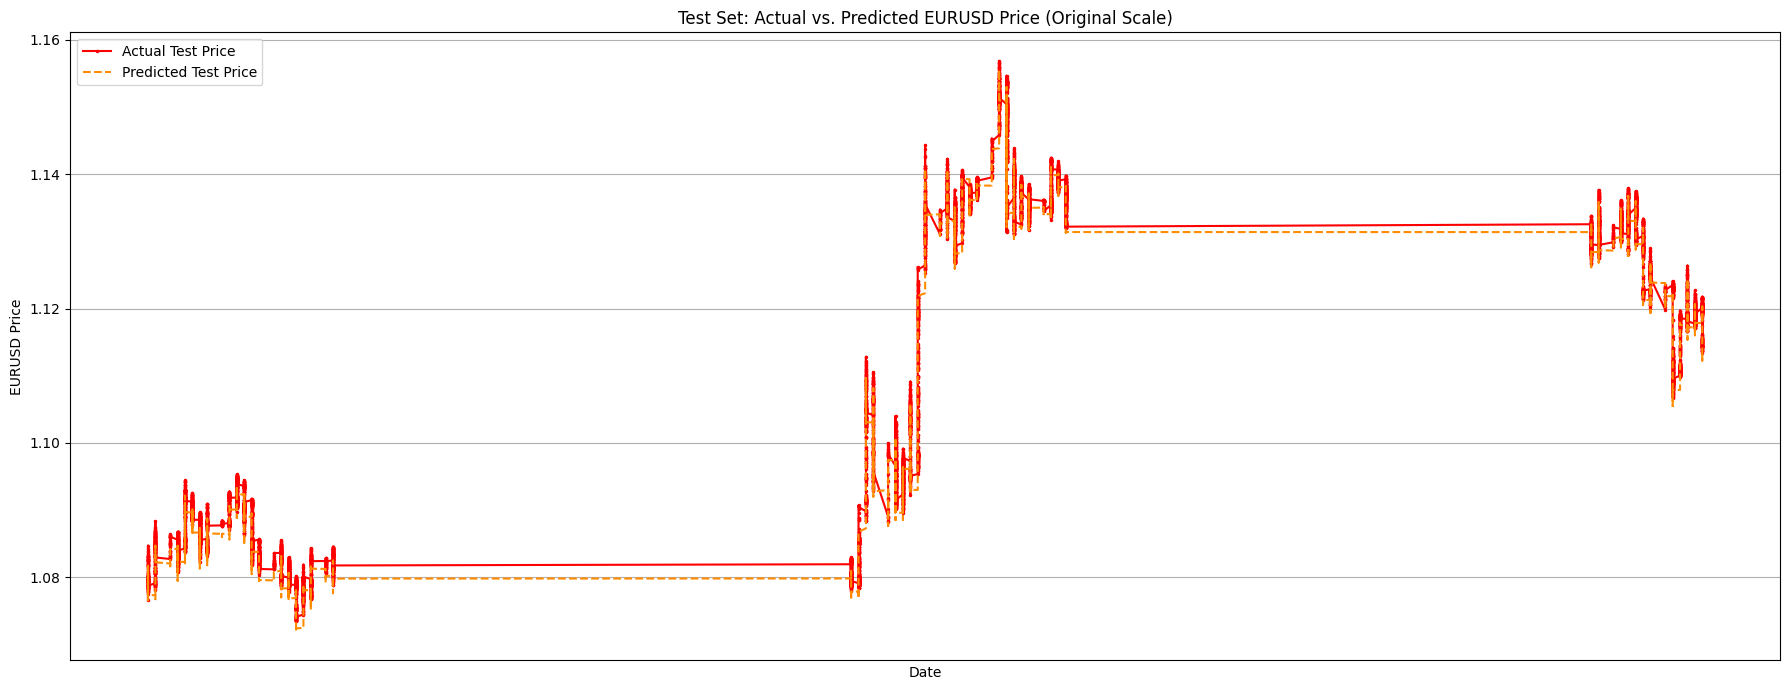

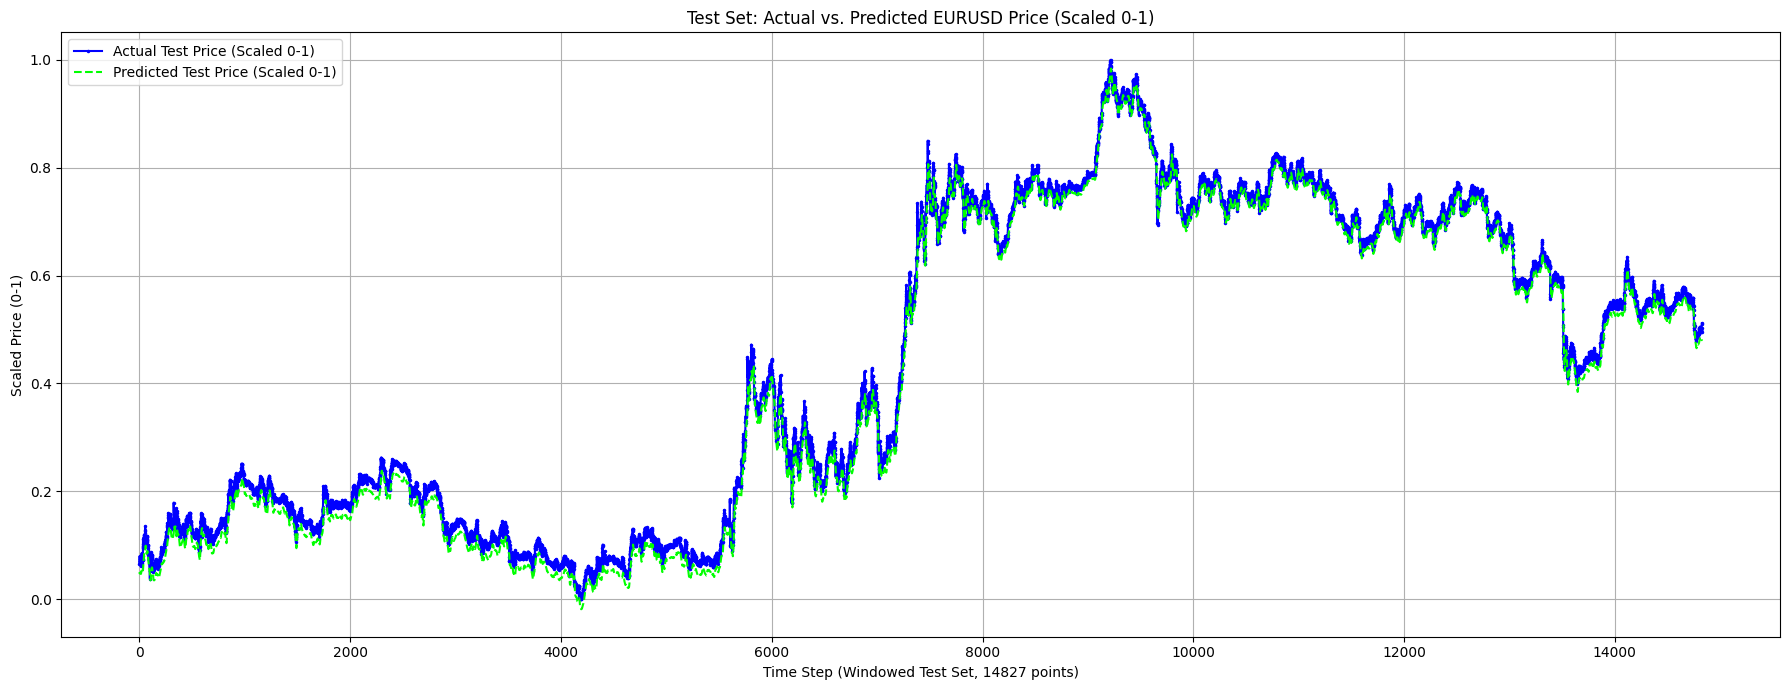

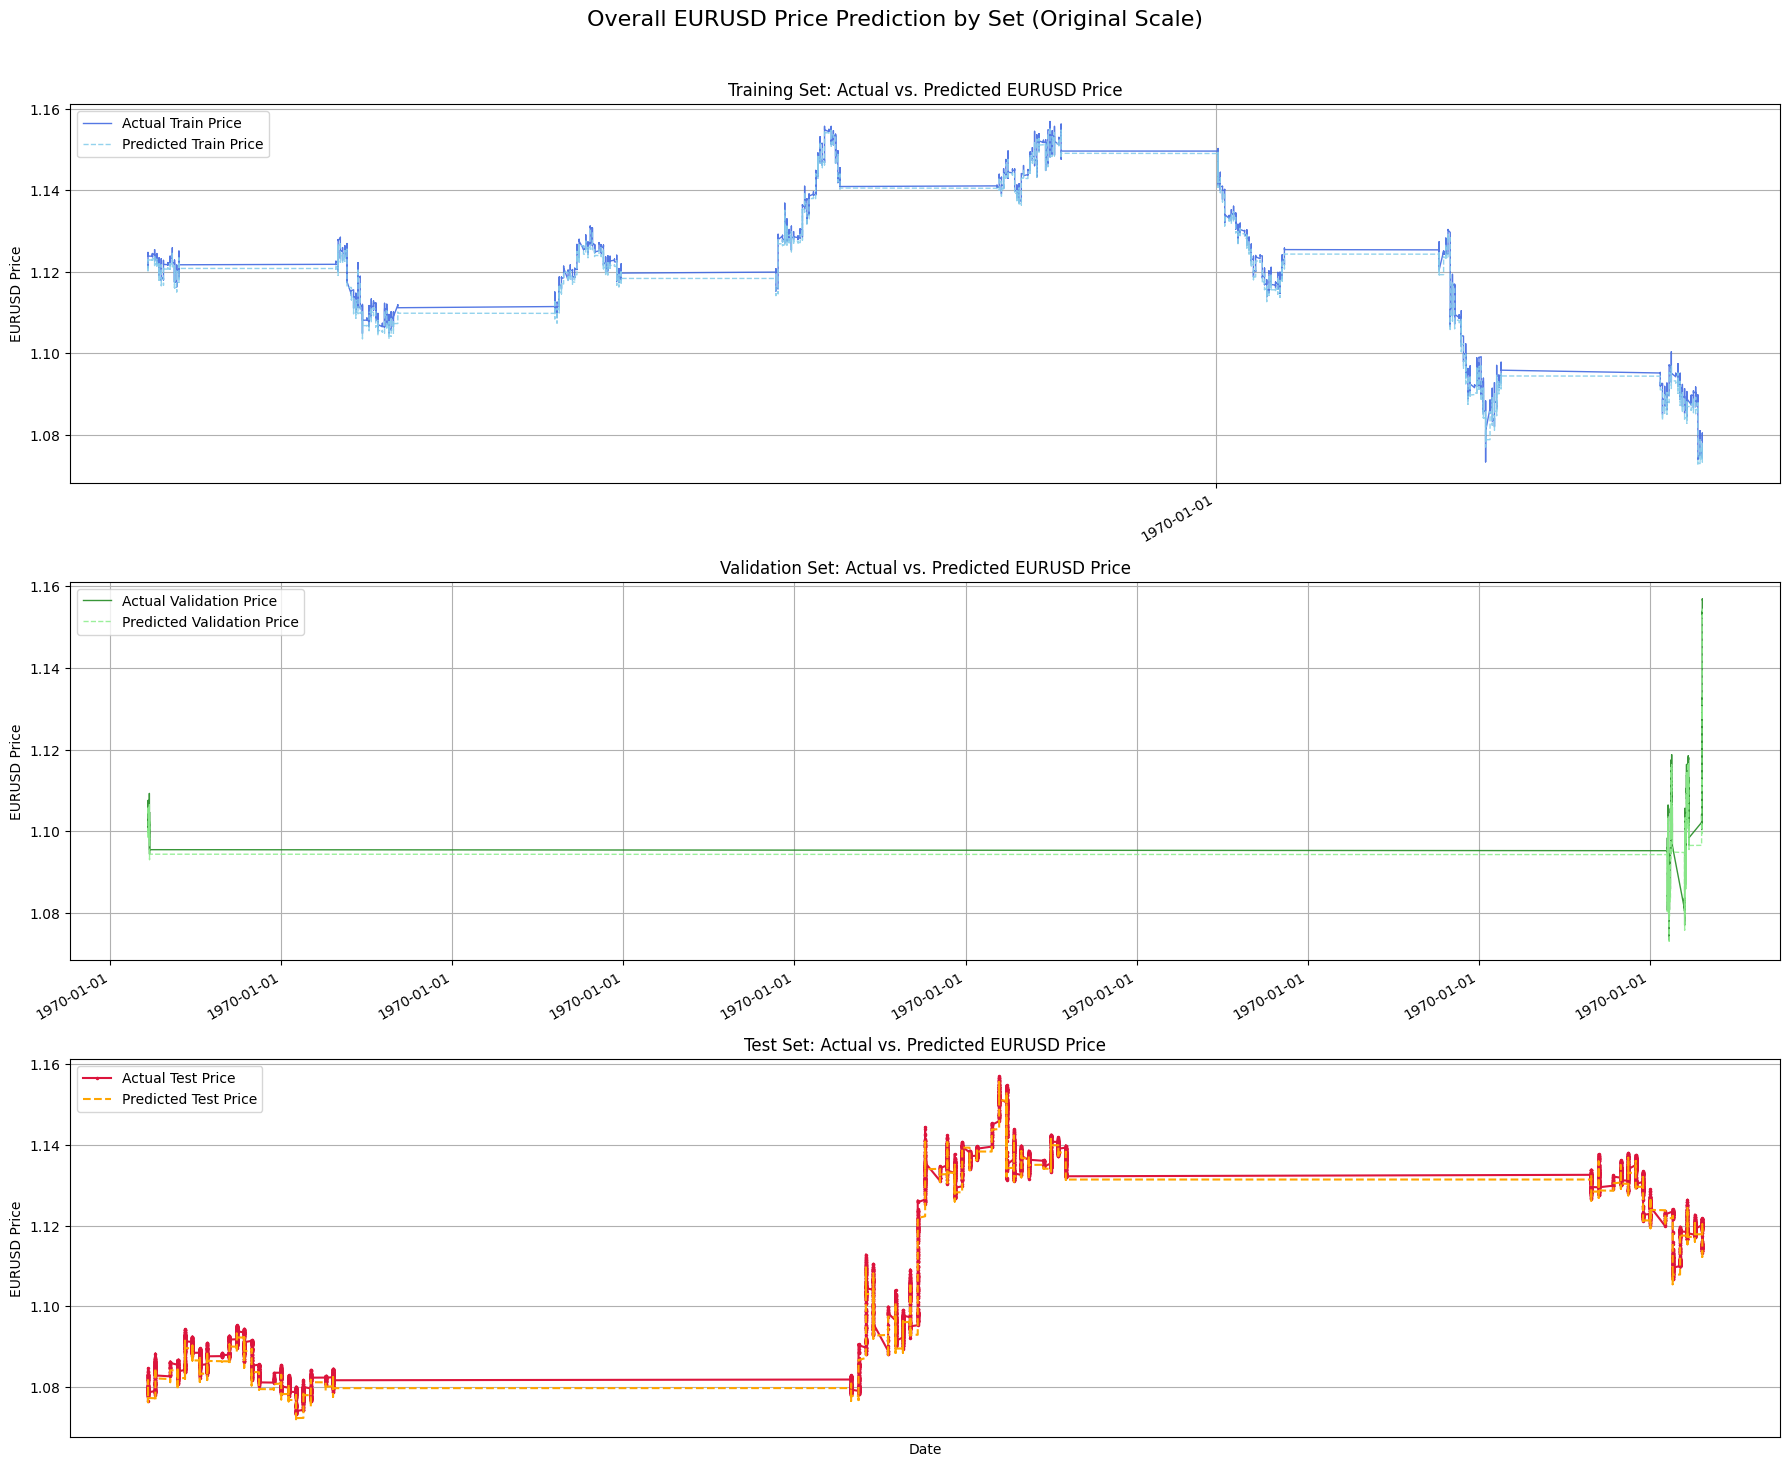

In [20]:
print("Generating plots...")

# --- PLOT 1: Detailed Test Set Comparison (Original Price Scale) ---
fig1, ax1 = plt.subplots(figsize=(18, 7)) # Create figure and axes
ax1.plot(test_dates, y_test_orig, color='red', marker='.', linestyle='-', markersize=3, label='Actual Test Price')
ax1.plot(test_dates, y_pred_test_orig, color='darkorange', linestyle='--', linewidth=1.5, label='Predicted Test Price')

ax1.set_title('Test Set: Actual vs. Predicted EURUSD Price (Original Scale)')
ax1.set_xlabel('Date')
ax1.set_ylabel('EURUSD Price')
ax1.legend(loc='upper left')
ax1.grid(True)

# Improve date ticks on x-axis for ax1
ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.setp(ax1.get_xticklabels(), rotation=30, ha='right') # Use plt.setp for properties
fig1.tight_layout() # Apply tight_layout to the figure
plt.show()

# --- PLOT 2: Detailed Test Set Comparison (Scaled 0-1 Price Scale) ---
fig2, ax2 = plt.subplots(figsize=(18, 7)) # Create figure and axes
time_steps_test = np.arange(len(y_test)) # y_test is scaled actuals for test
ax2.plot(time_steps_test, y_test, color='blue', marker='.', linestyle='-', markersize=3, label='Actual Test Price (Scaled 0-1)')
ax2.plot(time_steps_test, pred_test_scaled, color='lime', linestyle='--', linewidth=1.5, label='Predicted Test Price (Scaled 0-1)')

ax2.set_title('Test Set: Actual vs. Predicted EURUSD Price (Scaled 0-1)')
ax2.set_xlabel(f'Time Step (Windowed Test Set, {len(y_test)} points)')
ax2.set_ylabel('Scaled Price (0-1)')
ax2.legend(loc='upper left')
ax2.grid(True)
fig2.tight_layout() # Apply tight_layout to the figure
plt.show()

# --- PLOT 3: Overall View with Separate Subplots (Original Scale) ---
fig3, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=False) # sharex=False as time ranges are distinct

# Subplot 1: Training Data
axes[0].plot(train_dates, y_train_orig, color='royalblue', label='Actual Train Price', alpha=0.9, linewidth=1)
axes[0].plot(train_dates, y_pred_train_orig, color='skyblue', linestyle='--', label='Predicted Train Price', alpha=0.9, linewidth=1)
axes[0].set_title('Training Set: Actual vs. Predicted EURUSD Price')
axes[0].set_ylabel('EURUSD Price')
axes[0].legend(loc='upper left')
axes[0].grid(True)
axes[0].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=12, tz=None))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Show only date for broader view
plt.setp(axes[0].get_xticklabels(), rotation=30, ha='right')

# Subplot 2: Validation Data
axes[1].plot(val_dates, y_val_orig, color='forestgreen', label='Actual Validation Price', alpha=0.9, linewidth=1)
axes[1].plot(val_dates, y_pred_val_orig, color='lightgreen', linestyle='--', label='Predicted Validation Price', alpha=0.9, linewidth=1)
axes[1].set_title('Validation Set: Actual vs. Predicted EURUSD Price')
axes[1].set_ylabel('EURUSD Price')
axes[1].legend(loc='upper left')
axes[1].grid(True)
axes[1].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=12, tz=None))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Show only date
plt.setp(axes[1].get_xticklabels(), rotation=30, ha='right')

# Subplot 3: Test Data
axes[2].plot(test_dates, y_test_orig, color='crimson', marker='.', linestyle='-', markersize=3, label='Actual Test Price')
axes[2].plot(test_dates, y_pred_test_orig, color='orange', linestyle='--', linewidth=1.5, label='Predicted Test Price')
axes[2].set_title('Test Set: Actual vs. Predicted EURUSD Price')
axes[2].set_xlabel('Date') # Only set xlabel for the bottom-most plot
axes[2].set_ylabel('EURUSD Price')
axes[2].legend(loc='upper left')
axes[2].grid(True)
axes[2].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=15, tz=None))
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M')) # Date and Time for test
plt.setp(axes[2].get_xticklabels(), rotation=30, ha='right')

fig3.suptitle('Overall EURUSD Price Prediction by Set (Original Scale)', fontsize=16, y=1.005)
fig3.tight_layout(rect=[0, 0.03, 1, 0.99]) # Adjust rect to make space for suptitle and bottom labels
plt.show()

### Step 13: Quantitative Evaluation (Original Price Scale)

While visual inspection is important, quantitative metrics provide objective measures of the model's predictive accuracy on the original price scale.

*   **RMSE (Root Mean Squared Error):**
    *   Calculates the square root of the average of the squared differences between actual and predicted values.
    *   It penalizes larger errors more heavily.
    *   The result is in the same units as the target variable (EURUSD price). Lower is better.
*   **MAE (Mean Absolute Error):**
    *   Calculates the average of the absolute differences between actual and predicted values.
    *   It gives an average magnitude of the error.
    *   The result is also in the same units as the target variable. Lower is better.

We calculate these metrics primarily for the **test set** as it gives the most realistic estimate of the model's performance on new, unseen data.

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np # Ensure numpy is imported

# Calculate RMSE and MAE for the test set (original price scale)
rmse_test_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))
mae_test_orig = mean_absolute_error(y_test_orig, y_pred_test_orig)

print(f"Test Set RMSE (Original Scale): {rmse_test_orig:.6f} EURUSD") # Format to 6 decimal places
print(f"Test Set MAE (Original Scale): {mae_test_orig:.6f} EURUSD")

# Optionally, calculate for validation and training sets for comparison
if 'y_val_orig' in locals() and 'y_pred_val_orig' in locals(): # Check if validation variables exist
    rmse_val_orig = np.sqrt(mean_squared_error(y_val_orig, y_pred_val_orig))
    mae_val_orig = mean_absolute_error(y_val_orig, y_pred_val_orig)
    print(f"Validation Set RMSE (Original Scale): {rmse_val_orig:.6f} EURUSD")
    print(f"Validation Set MAE (Original Scale): {mae_val_orig:.6f} EURUSD")

if 'y_train_orig' in locals() and 'y_pred_train_orig' in locals(): # Check if training variables exist
    rmse_train_orig = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_orig))
    mae_train_orig = mean_absolute_error(y_train_orig, y_pred_train_orig)
    print(f"Training Set RMSE (Original Scale): {rmse_train_orig:.6f} EURUSD")
    print(f"Training Set MAE (Original Scale): {mae_train_orig:.6f} EURUSD")

# Interpreting these metrics:
# - How do these errors compare to the typical price fluctuations of EURUSD?
# - Is an MAE of, for example, 0.0005 EURUSD acceptable for a potential trading strategy based on 5-minute data?
# - Compare these to a baseline model (e.g., predicting the previous close) to see if the LSTM provides significant improvement.

Test Set RMSE (Original Scale): 0.001735 EURUSD
Test Set MAE (Original Scale): 0.001530 EURUSD
Validation Set RMSE (Original Scale): 0.001906 EURUSD
Validation Set MAE (Original Scale): 0.001759 EURUSD
Training Set RMSE (Original Scale): 0.001407 EURUSD
Training Set MAE (Original Scale): 0.001298 EURUSD
